# Análise de Séries Temporais - Coffee Sales
Você pode baixar os dados diretamente do [Kaggle](https://www.kaggle.com/datasets/ihelon/coffee-sales/data).


## Escolha da Série Temporal

Neste projeto, foi escolhida a série temporal de vendas diárias de café em uma máquina de venda automática. Essa escolha se justifica pela relevância do tema para negócios do setor alimentício, permitindo identificar padrões de consumo, tendências sazonais e preferências dos clientes. A análise desses dados pode auxiliar na tomada de decisões estratégicas, como reposição de estoque, promoções e previsão de demanda, além de ser um excelente exemplo prático de aplicação de técnicas de séries temporais.

In [75]:
# Importação das bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
import numpy as np
import cmdstanpy


In [81]:
# Carregamento e visualização dos dados de duas bases
df = pd.read_csv('index_1.csv')
print(df.columns)
df.head()



Index(['date', 'datetime', 'cash_type', 'card', 'money', 'coffee_name'], dtype='object')


,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte


### Análise Exploratória e Decomposição

In [84]:
# visualizando a estrutura geral dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   date         3636 non-null   object 
 1   datetime     3636 non-null   object 
 2   cash_type    3636 non-null   object 
 3   card         3547 non-null   object 
 4   money        3636 non-null   float64
 5   coffee_name  3636 non-null   object 
dtypes: float64(1), object(5)
memory usage: 170.6+ KB


In [85]:
# visualisando as estatísticas numericas dos dados
df.describe()

,money
count,3636.000000
mean,31.746859
std,4.919926
min,18.120000
25%,27.920000
50%,32.820000
75%,35.760000
max,40.000000


In [86]:
# verificando dados faltantes
df.isnull().sum()

,0
date,0
datetime,0
cash_type,0
card,89
money,0
coffee_name,0


In [87]:
# Removendo a coluna 'card' por não ser relevante para a análise de série temporal de vendas totais.
df.drop(columns='card', inplace=True)

In [88]:
# Convertendo as colunas relacionadas a tempo para o formato `datetime` e extraímos componentes como hora, data, mês e semana para uso posterior ou análise exploratória.

df["date"] = pd.to_datetime(df["date"])
df["datetime"] = pd.to_datetime(df["datetime"], format='mixed')

In [89]:
# visulisando como ficou as estruturas dos dados
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3636 entries, 0 to 3635
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         3636 non-null   datetime64[ns]
 1   datetime     3636 non-null   datetime64[ns]
 2   cash_type    3636 non-null   object        
 3   money        3636 non-null   float64       
 4   coffee_name  3636 non-null   object        
dtypes: datetime64[ns](2), float64(1), object(2)
memory usage: 142.2+ KB


In [93]:
#verificando novamente dados faltantes
df.isnull().sum()

,0
date,0
datetime,0
cash_type,0
money,0
coffee_name,0


In [94]:
# confirmando as colunas do Dataframe
df.columns

Index(['date', 'datetime', 'cash_type', 'money', 'coffee_name'], dtype='object')

In [95]:
# Identificando se existe Datas Faltantes

# Gerando todas as datas do intervalo esperado
datas_completas = pd.date_range(start=df['date'].min(), end=df['date'].max(), freq='D')

# Verificando quais datas estão faltando
datas_faltando  = datas_completas.difference(df['date'])

datas_faltando

DatetimeIndex(['2024-05-01', '2024-05-04', '2024-05-05', '2024-11-27',
               '2025-01-01', '2025-01-19', '2025-01-23'],
              dtype='datetime64[ns]', freq=None)

In [96]:
# Criando um DataFrame contendo todas as datas no intervalo, que servirá de base para garantir que a série temporal seja contínua.

df_datas_completas = pd.DataFrame(datas_completas, columns=["date"])

In [97]:
# Agrupamos o DataFrame original pela coluna date e contamos o número de transações por dia (usando count() na coluna 'money', que representa cada venda).
# Isso nos dá o número de "copos" vendidos por dia.
df_vendas_diarias = df.groupby('date')['money'].count().reset_index()

df_vendas_diarias

,date,money
0,2024-03-01,11
1,2024-03-02,7
2,2024-03-03,10
3,2024-03-04,4
4,2024-03-05,9
...,...,...
376,2025-03-19,21
377,2025-03-20,20
378,2025-03-21,20
379,2025-03-22,12


In [99]:
# Mesclado o DataFrame de datas completas com o DataFrame de vendas diárias agregadas. Usamos um left merge para manter todas as datas.
# O fillna(0) preenche os dias que não tinham vendas (datas faltantes) com 0.
# Renomeado as colunas para clareza. df_completo é a série temporal principal que vamos analisar e modelar.

df_completo = df_datas_completas.merge(df_vendas_diarias, on="date", how="left").fillna(0)
# Renomeia as colunas date para data e money para qtd_vendida, já que a coluna money foi agregada por quantidade (count())
df_completo.columns = ["data", "qtd_vendida"]
df_completo

,data,qtd_vendida
0,2024-03-01,11.0
1,2024-03-02,7.0
2,2024-03-03,10.0
3,2024-03-04,4.0
4,2024-03-05,9.0
...,...,...
383,2025-03-19,21.0
384,2025-03-20,20.0
385,2025-03-21,20.0
386,2025-03-22,12.0


In [100]:
# Retorna todas as linhas onde a coluna 'money' tem valor zero
df_zero = df_completo[df_completo['qtd_vendida'] == 0]
df_zero

,data,qtd_vendida
61,2024-05-01,0.0
64,2024-05-04,0.0
65,2024-05-05,0.0
271,2024-11-27,0.0
306,2025-01-01,0.0
324,2025-01-19,0.0
328,2025-01-23,0.0


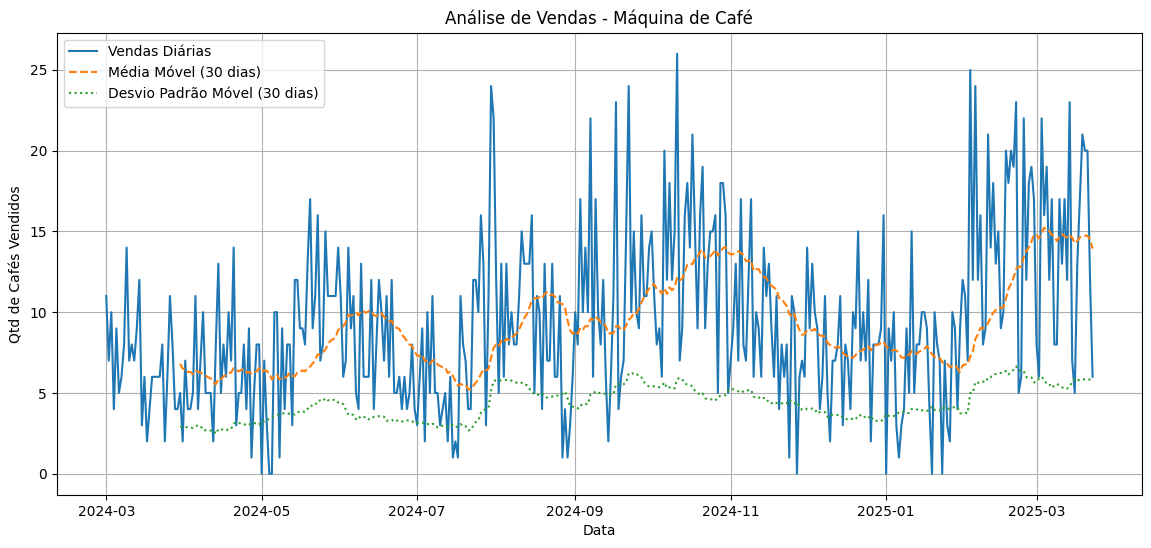

In [106]:
# transformando a coluna 'data' em índice do DataFrame
df_index_data = df_completo.set_index('data')

# Criando uma série (Series) com apenas os valores da coluna 'qtd_vendida'
serie_vendas = df_index_data['qtd_vendida']

# Calculando Media Movel Para detectar tendências mensais (entender a tendência real de crescimento ou queda)
media_movel = serie_vendas.rolling(window=30).mean()

#Calculando Desvio Padrão Movel
desvio_movel = serie_vendas.rolling(window=30).std()


plt.figure(figsize=(14,6))
plt.plot(serie_vendas, label='Vendas Diárias')
plt.plot(media_movel, label='Média Móvel (30 dias)', linestyle='--')
plt.plot(desvio_movel, label='Desvio Padrão Móvel (30 dias)', linestyle=':')
plt.xlabel('Data')
plt.ylabel('Qtd de Cafés Vendidos')
plt.title('Análise de Vendas - Máquina de Café')
plt.legend()
plt.grid()
plt.show()

### Interpretação do Gráfico: Análise de Vendas - Máquina de Café

O gráfico acima apresenta a evolução das vendas diárias de café em uma máquina automática, juntamente com a média móvel e o desvio padrão móvel dos últimos 30 dias.

**1. Linha Azul — Vendas Diárias**
- Representa a quantidade de cafés vendidos por dia.
- Observa-se alta variabilidade, com muitos picos e vales, indicando que a demanda diária é bastante volátil.
- Existem períodos com vendas significativamente maiores, especialmente entre setembro e novembro de 2024, e novamente a partir de fevereiro de 2025.

**2. Linha Laranja Tracejada — Média Móvel (30 dias)**
- Suaviza as oscilações diárias e evidencia a tendência geral das vendas.
- Nota-se um crescimento gradual nas vendas a partir de meados de 2024, com um pico entre outubro e novembro, seguido de uma queda em dezembro e janeiro, e nova alta a partir de fevereiro de 2025.
- Essa linha ajuda a identificar períodos de alta e baixa demanda, facilitando o planejamento de estoque e promoções.

**3. Linha Verde Pontilhada — Desvio Padrão Móvel (30 dias)**
- Mede a volatilidade das vendas nos últimos 30 dias.
- Períodos com desvio padrão mais alto indicam maior incerteza ou variação na demanda, como observado no segundo semestre de 2024.
- Em períodos mais estáveis, como início de 2025, o desvio padrão diminui, sugerindo vendas mais previsíveis.

**Resumo:**  
O gráfico mostra que as vendas de café apresentam forte variação diária, mas com tendências e padrões sazonais claros ao longo do tempo. A média móvel destaca os períodos de crescimento e queda, enquanto o desvio padrão móvel evidencia momentos de maior ou menor volatilidade. Essas informações são essenciais para a tomada de decisão em gestão de estoque, promoções e previsão de demanda.

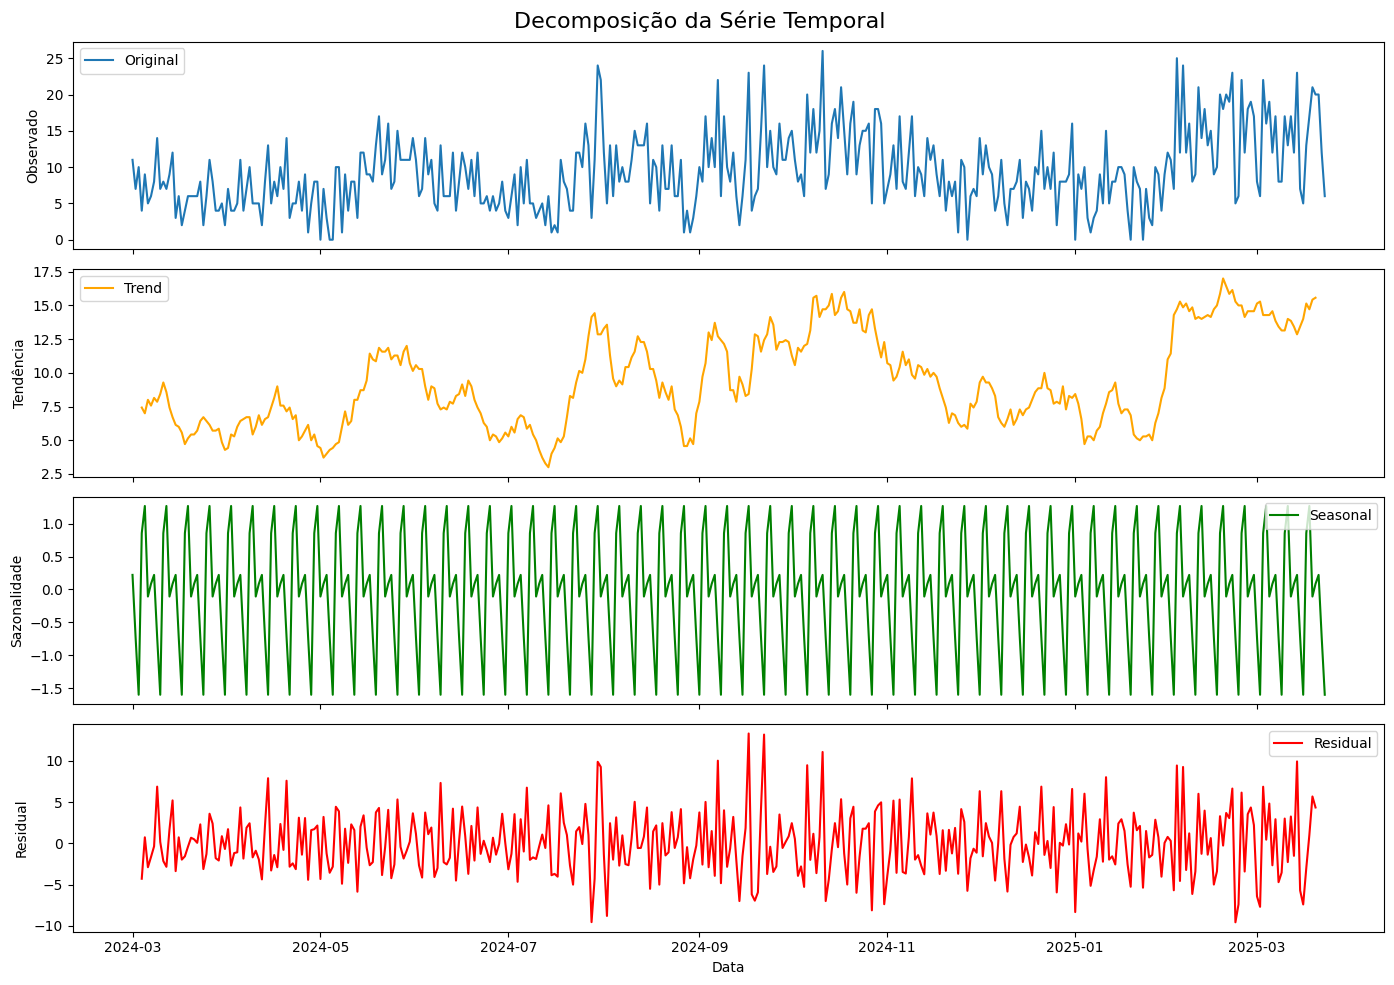

In [111]:
# Decomposição da série temporal
decomposicao = seasonal_decompose(serie_vendas, model='additive', period=7)

# Plotar os componentes

# Gráfico manual com maior tamanho
fig, axs = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axs[0].plot(decomposicao.observed, label='Original')
axs[0].set_ylabel('Observado')
axs[0].legend()

axs[1].plot(decomposicao.trend, label='Trend', color='orange')
axs[1].set_ylabel('Tendência')
axs[1].legend()

axs[2].plot(decomposicao.seasonal, label='Seasonal', color='green')
axs[2].set_ylabel('Sazonalidade')
axs[2].legend()

axs[3].plot(decomposicao.resid, label='Residual', color='red')
axs[3].set_ylabel('Residual')
axs[3].legend()

plt.suptitle('Decomposição da Série Temporal', fontsize=16)
plt.xlabel('Data')
plt.tight_layout()
plt.show()

## Interpretação da Decomposição da Série Temporal

A decomposição da série temporal de vendas diárias de café em uma máquina automática revelou os seguintes componentes e interpretações:

### 1. Observado (Original)
- **Linha azul:** Representa a série temporal real das vendas diárias.
- **O que mostra:** Alta variabilidade, com picos e vales ao longo do tempo, refletindo a dinâmica real das vendas.

### 2. Tendência (Trend)
- **Linha laranja:** Indica a tendência de longo prazo das vendas.
- **O que mostra:** Períodos de crescimento e estabilidade, sugerindo aumento de demanda ou fidelização de clientes em determinados intervalos.

### 3. Sazonalidade (Seasonal)
- **Linha verde:** Evidencia padrões que se repetem em ciclos semanais.
- **O que mostra:** Picos e vales regulares, indicando que há dias da semana com vendas consistentemente maiores ou menores, caracterizando uma forte sazonalidade semanal.

### 4. Resíduo (Residual)
- **Linha vermelha:** Representa as variações não explicadas pela tendência ou sazonalidade.
- **O que mostra:** Variações aleatórias, sem grandes outliers, indicando que a maior parte da variação foi capturada pelos componentes anteriores.

---


- **Tendência:** A série apresenta uma tendência de crescimento/estabilidade ao longo do tempo.
- **Sazonalidade:** Existe uma sazonalidade semanal bem definida, com padrões de vendas que se repetem a cada semana.
- **Ruído:** O componente residual é relativamente estável, sugerindo que os modelos que consideram tendência e sazonalidade (como Prophet e ARIMA/SARIMA) são adequados para previsão dessa série.

Essas características reforçam a importância de utilizar modelos que incorporem tanto tendência quanto sazonalidade para obter previsões mais precisas e úteis para a tomada de decisão no contexto de vendas de café.

## Implementação do modelo Prophet

O Prophet é um modelo de previsão de séries temporais desenvolvido pelo Facebook para facilitar a criação de previsões em dados com tendência e sazonalidade. Ele decompõe a série temporal em três componentes principais: tendência, sazonalidade e feriados/eventos especiais.

Tendência: captura o crescimento ou declínio ao longo do tempo (linear ou logística).

Sazonalidade: identifica padrões que se repetem em ciclos diários, semanais ou anuais.

Feriados: permite incluir datas especiais que afetam os dados.

É fácil de usar, robusto a dados com ruídos e faltantes, e gera previsões com intervalos de confiança. Ideal para séries temporais com padrões complexos e influência de eventos específicos.

In [112]:
# Preparação dos dados para o Prophet
df_prophet = serie_vendas.reset_index()
df_prophet.columns = ['ds', 'y']
df_prophet.head()

,ds,y
0,2024-03-01,11.0
1,2024-03-02,7.0
2,2024-03-03,10.0
3,2024-03-04,4.0
4,2024-03-05,9.0


In [113]:
# Função treinar_e_prever_prophet()

def treinar_e_prever_prophet(df_treino, df_teste):
    modelo = Prophet()
    modelo.fit(df_treino)
    futuro = modelo.make_future_dataframe(periods=len(df_teste))
    previsao = modelo.predict(futuro)
    datas = df_teste['ds'].tolist()
    previsao_filtrada = previsao[previsao['ds'].isin(datas)]
    previsao_filtrada = previsao_filtrada.set_index('ds').loc[datas].reset_index()
    return previsao_filtrada


In [114]:
# Validação Cruzada Temporal com Métricas

# Parâmetros da validação cruzada
tamanho_inicial_treino = int(len(df_prophet) * 0.6)
horizonte_previsao = int(len(df_prophet) * 0.1)

metricas_prophet = []

# Validação cruzada temporal
for i in range(tamanho_inicial_treino, len(df_prophet) - horizonte_previsao, horizonte_previsao):
    df_treino = df_prophet.iloc[:i]
    df_teste = df_prophet.iloc[i:i + horizonte_previsao]

    previsao = treinar_e_prever_prophet(df_treino, df_teste)

    mae = mean_absolute_error(df_teste['y'], previsao['yhat'])
    rmse = np.sqrt(mean_squared_error(df_teste['y'], previsao['yhat']))

    metricas_prophet.append({'mae': mae, 'rmse': rmse})
    print(f"Iteração {len(metricas_prophet)} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

mae_medio = np.mean([m['mae'] for m in metricas_prophet])
rmse_medio = np.mean([m['rmse'] for m in metricas_prophet])

print("\nMétricas Médias com Validação Cruzada Temporal para Prophet:")
print(f"MAE Médio: {mae_medio:.2f}")
print(f"RMSE Médio: {rmse_medio:.2f}")


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/1grpqx4y.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/7gwet0qj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=61265', 'data', 'file=/tmp/tmpr8net6m0/1grpqx4y.json', 'init=/tmp/tmpr8net6m0/7gwet0qj.json', 'output', 'file=/tmp/tmpr8net6m0/prophet_modelpezpgt63/prophet_model-20250519191935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Iteração 1 - MAE: 4.43, RMSE: 5.05
Iteração 2 - MAE: 4.85, RMSE: 5.73


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/luttzcb_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/opyavek0.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=78029', 'data', 'file=/tmp/tmpr8net6m0/luttzcb_.json', 'init=/tmp/tmpr8net6m0/opyavek0.json', 'output', 'file=/tmp/tmpr8net6m0/prophet_model46r2yenr/prophet_model-20250519191935.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:19:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:19:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Iteração 3 - MAE: 4.18, RMSE: 5.65
Iteração 4 - MAE: 6.50, RMSE: 7.80

Métricas Médias com Validação Cruzada Temporal para Prophet:
MAE Médio: 4.99
RMSE Médio: 6.06


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/q0qh2tpl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/4m2a7hcl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=36391', 'data', 'file=/tmp/tmpr8net6m0/q0qh2tpl.json', 'init=/tmp/tmpr8net6m0/4m2a7hcl.json', 'output', 'file=/tmp/tmpr8net6m0/prophet_modeldm7y5jcq/prophet_model-20250519192004.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:20:04 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:20:04 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

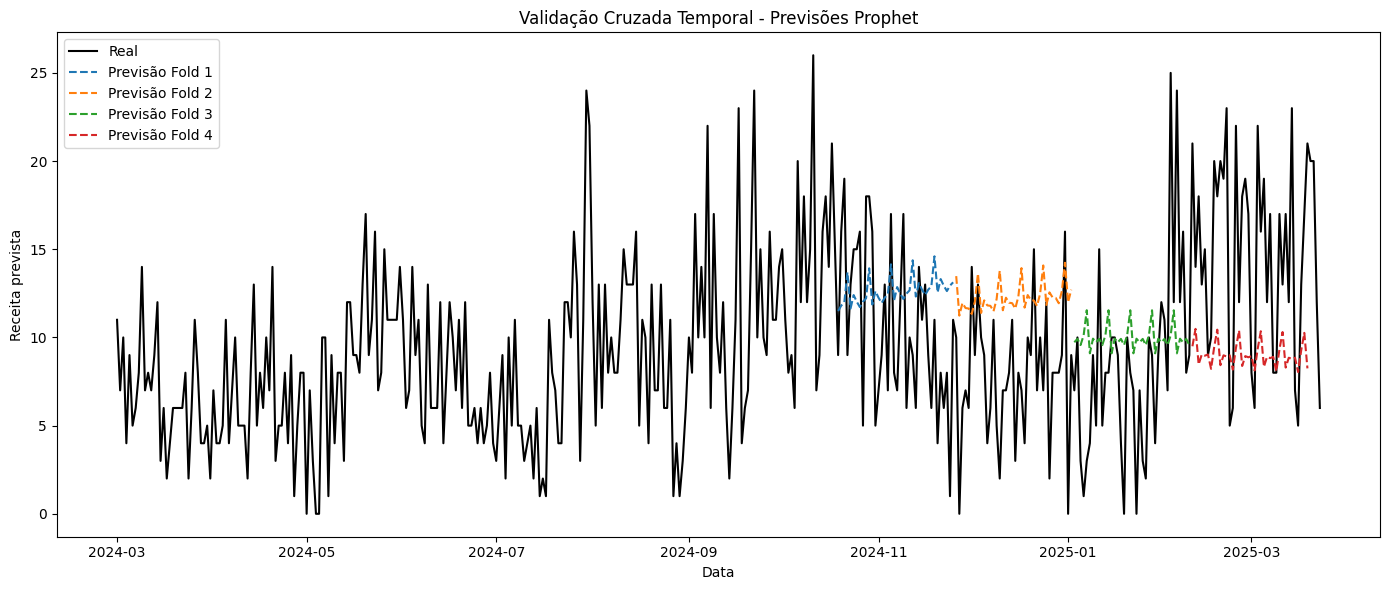

In [115]:
# Visualização das Previsões por Fold

plt.figure(figsize=(14, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Real', color='black')

for i in range(len(metricas_prophet)):
    inicio = tamanho_inicial_treino + i * horizonte_previsao
    fim = inicio + horizonte_previsao
    if fim > len(df_prophet):
        break
    df_treino = df_prophet.iloc[:inicio]
    df_teste = df_prophet.iloc[inicio:fim]

    previsao = treinar_e_prever_prophet(df_treino, df_teste)

    plt.plot(df_teste['ds'], previsao['yhat'], label=f'Previsão Fold {i+1}', linestyle='--')

plt.title('Validação Cruzada Temporal - Previsões Prophet')
plt.xlabel('Data')
plt.ylabel('Receita prevista')
plt.legend()
plt.tight_layout()
plt.show()


### Interpretação do Gráfico: Validação Cruzada Temporal - Previsões Prophet

O gráfico apresenta a validação cruzada temporal das previsões do modelo Prophet para a receita diária de vendas de café.

- **Linha preta (Real):** Representa a série temporal real da receita diária ao longo do tempo.
- **Linhas tracejadas coloridas:** Cada cor corresponde às previsões do Prophet para um fold (janela de teste) diferente da validação cruzada temporal (Fold 1, Fold 2, Fold 3, Fold 4).

#### O que o gráfico mostra:

- **Aderência à tendência:** As previsões do Prophet seguem a tendência geral da série real, mas suavizam as oscilações mais bruscas.
- **Previsão por fold:** Cada fold faz previsões apenas para o seu período de teste, sem sobrepor os dados de treino. Isso simula como o modelo se comportaria ao prever períodos futuros em diferentes momentos históricos.
- **Variação entre folds:** Pequenas diferenças entre as previsões dos folds são esperadas, pois cada um utiliza um período de treino diferente.
- **Limitação em picos e vales:** O Prophet não consegue capturar picos e vales extremos, priorizando o padrão geral da série.

#### Resumo:

O gráfico evidencia que o Prophet é eficiente para capturar tendências e padrões sazonais, mas tende a suavizar as variações diárias mais abruptas. A validação cruzada temporal é importante para avaliar a estabilidade e a capacidade preditiva do modelo ao longo do tempo, mostrando que o Prophet mantém desempenho consistente em diferentes períodos históricos, mesmo que não antecipe oscilações pontuais.

### Remoção de Tendência e/ou Sazonalidade Para implementar no modelo ARIMA

In [116]:
# Teste Aumentado de Dickey-Fuller para verificar estacionaridade
resultado_adf = adfuller(serie_vendas)

print(f'Estatística ADF: {resultado_adf[0]}')
print(f'Valor-p: {resultado_adf[1]}')
print('Valores Críticos:')
for chave, valor in resultado_adf[4].items():
    print(f'\t{chave}: {valor}')

if resultado_adf[1] <= 0.05:
    print("\nA série é estacionária (rejeitamos a hipótese nula).")
else:
    print("\nA série NÃO é estacionária (não rejeitamos a hipótese nula).")

Estatística ADF: -3.0620700612598553
Valor-p: 0.029490510579497288
Valores Críticos:
	1%: -3.4476305904172904
	5%: -2.869155980820355
	10%: -2.570827146203181

A série é estacionária (rejeitamos a hipótese nula).


Interpretação do resultado do Teste ADF:

Estatística ADF: Quanto mais negativa, maior a probabilidade de a série ser estacionária.

Valor-p: É o mais importante. Se o valor-p for menor ou igual a um nível de significância (geralmente 0.05), rejeitamos a hipótese nula e concluímos que a série é estacionária.

Valores Críticos: São limiares para comparar a Estatística ADF em diferentes níveis de confiança. Se a Estatística ADF for menor que o valor crítico em um determinado nível de confiança, a série é considerada estacionária nesse nível.

### Análise de ACF e PACF  para ajudar a determinar os parâmetros p e q do modelo ARIMA.

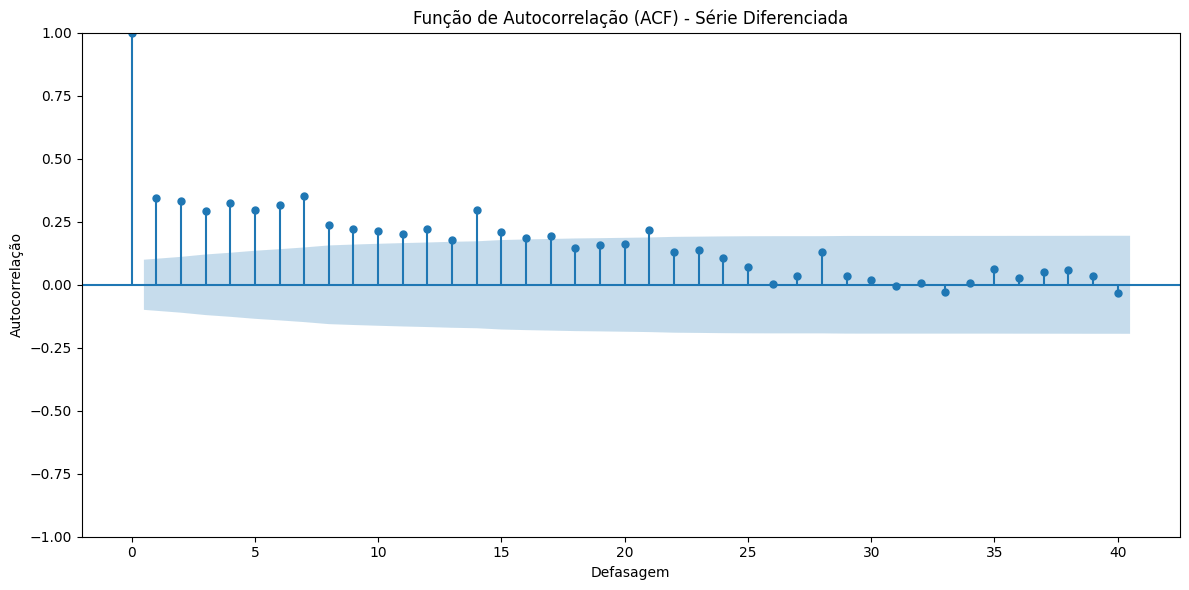

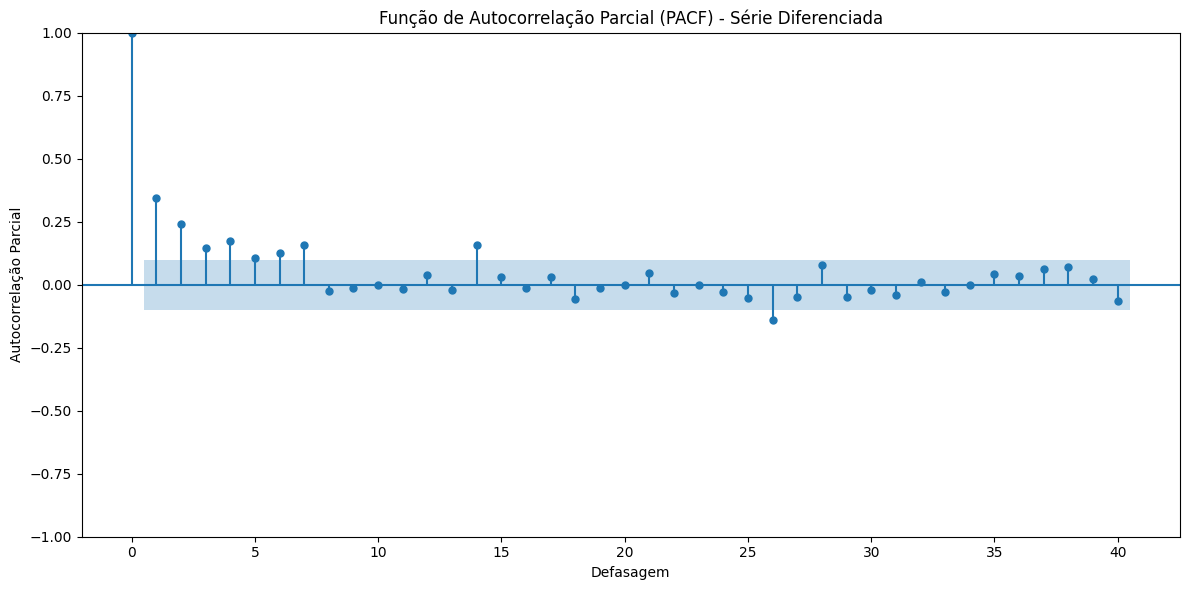

In [117]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plotagem do ACF para a série diferenciada
plt.figure(figsize=(12, 6))
plot_acf(serie_vendas, lags=40, ax=plt.gca())
plt.title('Função de Autocorrelação (ACF) - Série Diferenciada')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação')
plt.tight_layout()
plt.show()

# Plotagem do PACF para a série diferenciada
plt.figure(figsize=(12, 6))
plot_pacf(serie_vendas, lags=40, ax=plt.gca())
plt.title('Função de Autocorrelação Parcial (PACF) - Série Diferenciada')
plt.xlabel('Defasagem')
plt.ylabel('Autocorrelação Parcial')
plt.tight_layout()
plt.show()

### Interpretação do Gráfico: Função de Autocorrelação (ACF) - Série Diferenciada

O gráfico acima mostra a Função de Autocorrelação (ACF) da série temporal de vendas de café após a diferenciação (remoção de tendência).

**Principais pontos:**

- **Defasagem 1:** A barra na defasagem 1 é significativa, indicando forte autocorrelação entre o valor atual e o valor imediatamente anterior. Isso sugere que o termo de média móvel (q) deve ser considerado no modelo ARIMA.
- **Decaimento rápido:** Após a defasagem 1, as autocorrelações caem rapidamente, ficando próximas de zero e dentro da faixa azul (intervalo de confiança). Isso indica que não há autocorrelação significativa em defasagens maiores.
- **Sazonalidade:** Observa-se algumas barras levemente acima da faixa azul em múltiplos de 7, sugerindo possível sazonalidade semanal, mas o efeito não é muito forte.
- **Ruído branco:** A maioria das barras após as primeiras defasagens está dentro da faixa azul, indicando que a série diferenciada se comporta como ruído branco (sem autocorrelação significativa).

**Resumo:**  
O gráfico sugere que um modelo ARIMA com q=1 pode ser adequado para o componente não sazonal. A presença de algumas barras em múltiplos de 7 pode indicar sazonalidade semanal, sugerindo que um modelo SARIMA pode capturar melhor esse padrão.

### Interpretação do Gráfico: Função de Autocorrelação Parcial (PACF) - Série Diferenciada

O gráfico acima apresenta a Função de Autocorrelação Parcial (PACF) da série temporal de vendas de café após a diferenciação (remoção da tendência).

**Principais pontos:**

- **Defasagem 1:** A barra na defasagem 1 é significativamente alta, indicando que o valor atual da série está fortemente relacionado apenas ao valor imediatamente anterior, após a diferenciação.
- **Corte abrupto:** Após a defasagem 1, as barras caem rapidamente e ficam dentro da faixa azul (intervalo de confiança), sugerindo que não há autocorrelação parcial significativa em defasagens maiores.
- **Sazonalidade:** Não há barras significativas em múltiplos de 7, indicando ausência de sazonalidade semanal relevante na autocorrelação parcial.
- **Ruído branco:** A maioria das barras após a primeira defasagem está dentro do intervalo de confiança, sugerindo que a série diferenciada se comporta como ruído branco (sem autocorrelação parcial relevante).

**Resumo:**  
O gráfico PACF sugere que um modelo ARIMA com **p=1** é apropriado, pois a autocorrelação parcial é significativa apenas na primeira defasagem e se dissipa rapidamente nas demais. Isso indica que o valor de hoje depende principalmente do valor de ontem, e não de períodos mais distantes.

### Divisão dos Dados e Modelagem para o ARIMA

In [121]:
# Função para treinar e prever com ARIMA

def treinar_e_prever_arima(serie_treino, serie_teste, order):
    # O modelo ARIMA assume que a série de entrada é a série original
    # e o parâmetro 'order' lida com a diferenciação
    modelo = ARIMA(serie_treino, order=order)
    resultado = modelo.fit()

    # O método forecast() prevê para o número especificado de passos à frente
    previsao = resultado.forecast(steps=len(serie_teste))

    # Retornar um DataFrame similar ao do Prophet para facilitar a comparação
    previsao_df = pd.DataFrame({
        'ds': serie_teste.index,
        'yhat': previsao.values # previsao.values contém os valores previstos
    })
    return previsao_df

In [122]:
# Ordem do modelo ARIMA com base na análise de ACF/PACF e ADF
ordem_arima_definida = (1, 1, 1)

# Validação Cruzada Temporal com Métricas para ARIMA

# Parâmetros da validação cruzada
tamanho_inicial_treino = int(len(serie_vendas) * 0.6) # Usando o tamanho da série original
horizonte_previsao = int(len(serie_vendas) * 0.1)   # Usando o tamanho da série original

metricas_arima = [] # Lista para as métricas do ARIMA

# Validação cruzada temporal
# Loop sobre os índices da série original
for i in range(tamanho_inicial_treino, len(serie_vendas) - horizonte_previsao, horizonte_previsao):

    # Para o ARIMA, precisamos da série temporal na escala original (objeto Series do pandas)
    # O objeto 'serie' já está com o índice de data e valores agregados diariamente
    serie_treino_arima = serie_vendas.iloc[:i]
    serie_teste_arima = serie_vendas.iloc[i:i + horizonte_previsao]

    # Previsão com ARIMA
    try:
        previsao_arima = treinar_e_prever_arima(serie_treino_arima, serie_teste_arima, ordem_arima_definida)
        # Comparar com os valores reais da série_teste_arima (objeto Series)
        mae_arima = mean_absolute_error(serie_teste_arima.values, previsao_arima['yhat'])
        rmse_arima = np.sqrt(mean_squared_error(serie_teste_arima.values, previsao_arima['yhat']))
        metricas_arima.append({'mae': mae_arima, 'rmse': rmse_arima})
        print(f"Iteração {len(metricas_arima)} - ARIMA (MAE: {mae_arima:.2f}, RMSE: {rmse_arima:.2f})")
    except Exception as e:
        # Tratar possíveis erros durante o treinamento do ARIMA (pode acontecer com certas ordens ou dados)
        print(f"Erro ao treinar ou prever com ARIMA na iteração {len(metricas_arima) + 1}: {e}")
        metricas_arima.append({'mae': np.nan, 'rmse': np.nan}) # Adicionar NaN para não quebrar o cálculo da média

# Cálculo das métricas médias
mae_medio_arima = np.nanmean([m['mae'] for m in metricas_arima]) # Usar nanmean para ignorar NaNs se houver erros
rmse_medio_arima = np.nanmean([m['rmse'] for m in metricas_arima])

print("\nMétricas Médias com Validação Cruzada Temporal para ARIMA:")
print(f"MAE Médio: {mae_medio_arima:.2f}")
print(f"RMSE Médio: {rmse_medio_arima:.2f}")

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Iteração 1 - ARIMA (MAE: 5.47, RMSE: 6.54)
Iteração 2 - ARIMA (MAE: 2.79, RMSE: 3.67)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

Iteração 3 - ARIMA (MAE: 3.79, RMSE: 5.37)
Iteração 4 - ARIMA (MAE: 5.25, RMSE: 6.05)

Métricas Médias com Validação Cruzada Temporal para ARIMA:
MAE Médio: 4.33
RMSE Médio: 5.41


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dat

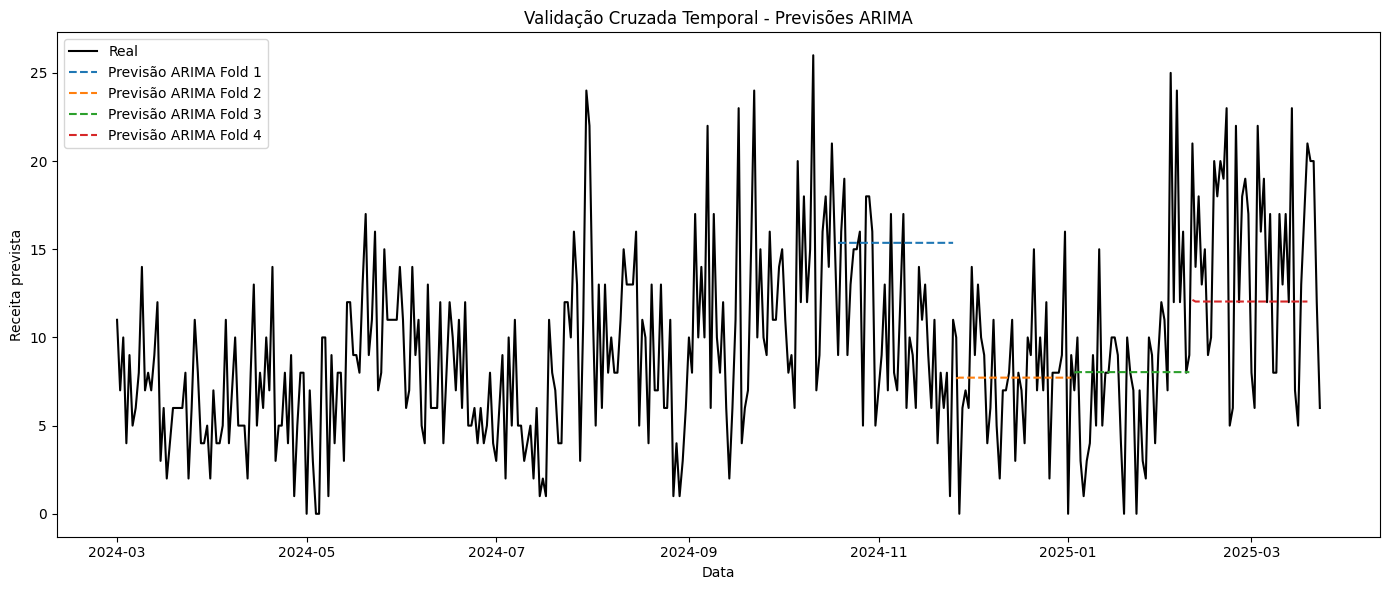

In [123]:
# Visualização das Previsões por Fold para ARIMA

plt.figure(figsize=(14, 6))
# Plotar a série real completa para referência
plt.plot(serie_vendas.index, serie_vendas.values, label='Real', color='black')

# Parâmetros da validação cruzada (certifique-se de que são os mesmos usados na avaliação)
tamanho_inicial_treino = int(len(serie_vendas) * 0.6)
horizonte_previsao = int(len(serie_vendas) * 0.1)
ordem_arima_definida = (1, 1, 1) # Use a ordem que você definiu

# Loop para gerar previsões em cada fold e plotar
# O loop itera sobre os índices da série original
fold_count = 0 # Contador para o número do fold
for i in range(tamanho_inicial_treino, len(serie_vendas) - horizonte_previsao, horizonte_previsao):
    fold_count += 1
    inicio = i
    fim = i + horizonte_previsao

    # Certificar-se de que o fold de teste não ultrapassa o tamanho da série
    if fim > len(serie_vendas):
        break

    # Extrair dados de treino e teste para o fold atual
    serie_treino_arima = serie_vendas.iloc[:inicio]
    serie_teste_arima = serie_vendas.iloc[inicio:fim]

    # Gerar previsões para o fold de teste
    try:
        previsao_arima = treinar_e_prever_arima(serie_treino_arima, serie_teste_arima, ordem_arima_definida)

        # Plotar as previsões do ARIMA para o fold atual
        # Use um rótulo único para cada fold
        plt.plot(previsao_arima['ds'], previsao_arima['yhat'], label=f'Previsão ARIMA Fold {fold_count}', linestyle='--')

    except Exception as e:
        print(f"Erro ao gerar previsão para plotagem do ARIMA no Fold {fold_count}: {e}")
        # Se ocorrer um erro, não plotamos este fold

plt.title('Validação Cruzada Temporal - Previsões ARIMA')
plt.xlabel('Data')
plt.ylabel('Receita prevista')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretação do Gráfico de Validação Cruzada Temporal - Previsões ARIMA

O gráfico apresenta a validação cruzada temporal das previsões do modelo ARIMA para a receita diária de vendas de café.

- **Linha preta (Real):** Representa a série temporal real da receita diária ao longo do tempo.
- **Linhas tracejadas coloridas:** Cada cor corresponde às previsões do ARIMA para um fold (janela de teste) diferente da validação cruzada temporal, como "Previsão ARIMA Fold 1", "Fold 2" etc.
- **Cada fold:** O modelo é treinado até certo ponto da série e faz previsões para o próximo intervalo (horizonte de previsão). Isso é repetido em diferentes pontos da série, simulando previsões em diferentes períodos históricos.
- **Sobreposição:** As previsões aparecem apenas nos períodos de teste de cada fold, sem sobrepor os dados de treino.

#### O que o gráfico mostra:

- O ARIMA consegue capturar a tendência geral da série, mas suaviza as oscilações mais bruscas.
- As previsões de cada fold são feitas apenas para o período de teste correspondente, mostrando como o modelo se comporta em diferentes momentos históricos.
- Pequenas diferenças entre as previsões dos folds são esperadas, pois cada um utiliza um período de treino diferente.

O gráfico é útil para avaliar a **estabilidade** e a **capacidade preditiva** do ARIMA ao longo do tempo. Ele mostra que o modelo tende a seguir o padrão geral da série, mas pode não capturar picos e vales extremos, o que é típico de modelos ARIMA em séries com alta variabilidade. Isso reforça a importância de comparar com outros modelos e ajustar os parâmetros conforme necessário.

As linhas tracejadas aparecem retas porque, para cada janela de teste, o ARIMA faz previsões que mudam pouco entre os dias previstos daquele fold. Isso é um comportamento comum do ARIMA em previsões multi-passos, especialmente em séries com alta variabilidade e modelos simples.

Por isso abaixo foi feito previsões mais dinâmicas, reduzindo o horizonte de previsão (previsão de 1 passo por vez). E comparando os modelos.

### Compararação do desempenho dos modelos em um horizonte de previsão de 1 passo

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/hs3h9buj.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8net6m0/_4qdxf2v.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=44814', 'data', 'file=/tmp/tmpr8net6m0/hs3h9buj.json', 'init=/tmp/tmpr8net6m0/_4qdxf2v.json', 'output', 'file=/tmp/tmpr8net6m0/prophet_modelha4kg9aj/prophet_model-20250519193843.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:38:43 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:38:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages/


Métricas de Desempenho - Previsão de 1 Passo:
Prophet:
MAE: 4.42
RMSE: 5.51

ARIMA:
MAE: 3.92
RMSE: 4.96


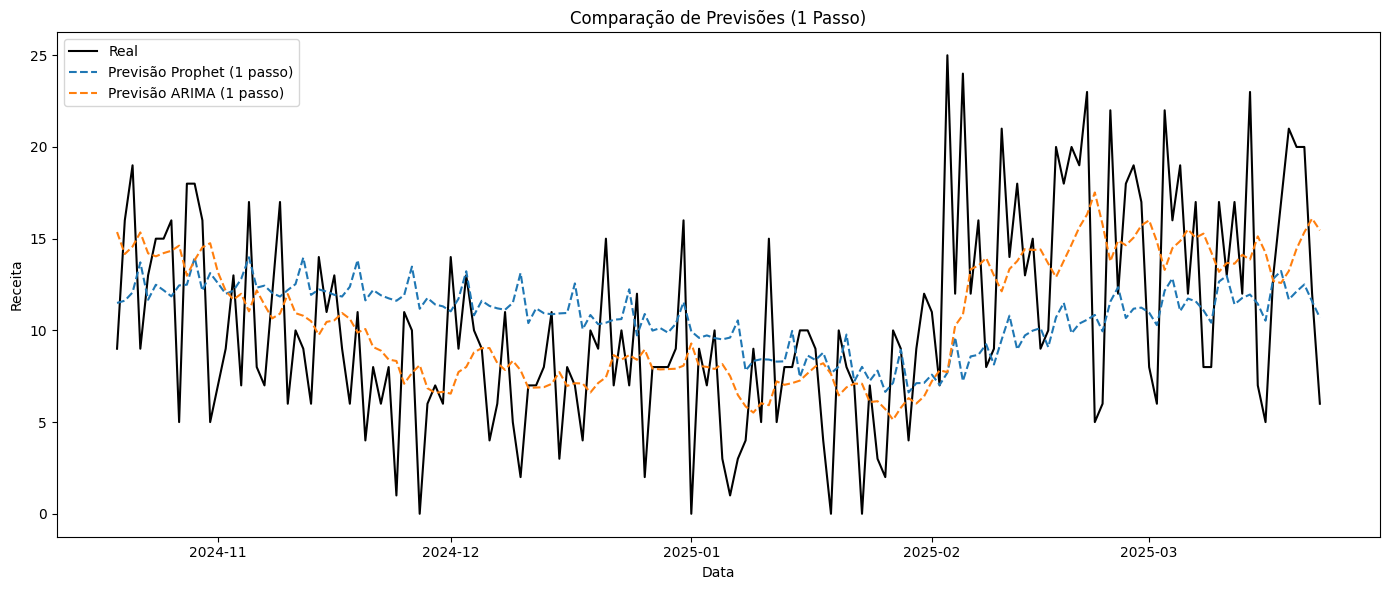

In [125]:
# Comparação de Desempenho - Previsão de 1 Passo

# Definir o tamanho inicial do treino (pode ser o mesmo da validação cruzada ou um valor fixo)
tamanho_inicial_treino_1_passo = int(len(serie_vendas) * 0.6) # Ou outro valor apropriado

previsoes_reais_1_passo = []
previsoes_prophet_1_passo = []
previsoes_arima_1_passo = []

# Loop para previsão de 1 passo
# Começa onde termina o tamanho inicial do treino
for i in range(tamanho_inicial_treino_1_passo, len(serie_vendas)):

    # Obter dados de treino para o passo atual
    df_treino_prophet = df_prophet.iloc[:i]
    serie_treino_arima = serie_vendas.iloc[:i]

    # Obter o valor real do próximo passo
    if i < len(serie_vendas):
        valor_real_proximo_passo = serie_vendas.iloc[i]
        data_proximo_passo = serie_vendas.index[i]
    else:
        # Isso só aconteceria se o loop chegasse ao fim da série
        break # Sair do loop se não houver mais dados reais para comparar

    # Armazenar o valor real
    previsoes_reais_1_passo.append({'ds': data_proximo_passo, 'y': valor_real_proximo_passo})

    # Prever 1 passo à frente com Prophet
    try:
        # Prophet precisa de um DataFrame de futuro com a data do próximo passo
        futuro_prophet_1_passo = pd.DataFrame({'ds': [data_proximo_passo]})
        previsao_prophet = Prophet().fit(df_treino_prophet).predict(futuro_prophet_1_passo)
        previsoes_prophet_1_passo.append({'ds': data_proximo_passo, 'yhat': previsao_prophet['yhat'].iloc[0]})
    except Exception as e:
        print(f"Erro ao prever 1 passo com Prophet na data {data_proximo_passo}: {e}")
        previsoes_prophet_1_passo.append({'ds': data_proximo_passo, 'yhat': np.nan})


    # Prever 1 passo à frente com ARIMA
    try:
        # ARIMA prevê o número especificado de passos à frente (aqui 1)
        modelo_arima_1_passo = ARIMA(serie_treino_arima, order=ordem_arima_definida)
        resultado_arima_1_passo = modelo_arima_1_passo.fit()
        previsao_arima = resultado_arima_1_passo.forecast(steps=1)
        previsoes_arima_1_passo.append({'ds': data_proximo_passo, 'yhat': previsao_arima.iloc[0]}) # ARIMA forecast retorna uma Series ou array
    except Exception as e:
        print(f"Erro ao prever 1 passo com ARIMA na data {data_proximo_passo}: {e}")
        previsoes_arima_1_passo.append({'ds': data_proximo_passo, 'yhat': np.nan})


# Converter listas de previsões para DataFrames para facilitar o cálculo de métricas
df_reais_1_passo = pd.DataFrame(previsoes_reais_1_passo).set_index('ds')
df_prophet_1_passo = pd.DataFrame(previsoes_prophet_1_passo).set_index('ds')
df_arima_1_passo = pd.DataFrame(previsoes_arima_1_passo).set_index('ds')

# Juntar os DataFrames para garantir que as comparações sejam feitas nas mesmas datas
df_comparacao_1_passo = df_reais_1_passo.join(df_prophet_1_passo, rsuffix='_prophet').join(df_arima_1_passo, rsuffix='_arima').dropna()


# Calcular métricas de avaliação para previsão de 1 passo
mae_prophet_1_passo = mean_absolute_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat'])
rmse_prophet_1_passo = np.sqrt(mean_squared_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat']))

mae_arima_1_passo = mean_absolute_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat_arima']) # Usar 'yhat_arima' após o join
rmse_arima_1_passo = np.sqrt(mean_squared_error(df_comparacao_1_passo['y'], df_comparacao_1_passo['yhat_arima']))


print("\nMétricas de Desempenho - Previsão de 1 Passo:")
print("Prophet:")
print(f"MAE: {mae_prophet_1_passo:.2f}")
print(f"RMSE: {rmse_prophet_1_passo:.2f}")
print("\nARIMA:")
print(f"MAE: {mae_arima_1_passo:.2f}")
print(f"RMSE: {rmse_arima_1_passo:.2f}")

# Opcional: Visualizar as previsões de 1 passo
plt.figure(figsize=(14, 6))
plt.plot(df_comparacao_1_passo.index, df_comparacao_1_passo['y'], label='Real', color='black')
plt.plot(df_comparacao_1_passo.index, df_comparacao_1_passo['yhat'], label='Previsão Prophet (1 passo)', linestyle='--')
plt.plot(df_comparacao_1_passo.index, df_comparacao_1_passo['yhat_arima'], label='Previsão ARIMA (1 passo)', linestyle='--')
plt.title('Comparação de Previsões (1 Passo)')
plt.xlabel('Data')
plt.ylabel('Receita')
plt.legend()
plt.tight_layout()
plt.show()

### Interpretação do Gráfico: Comparação de Previsões (1 Passo)

O gráfico acima compara as previsões de 1 passo à frente dos modelos Prophet e ARIMA com a série real de receita diária de vendas de café.

- **Linha preta (Real):** Representa a receita diária real, mostrando alta variabilidade, com picos e vales acentuados.
- **Linha azul tracejada (Prophet):** Mostra as previsões do Prophet para cada dia, sempre prevendo apenas o próximo valor.
- **Linha laranja tracejada (ARIMA):** Mostra as previsões do ARIMA para cada dia, também prevendo apenas o próximo valor.

#### O que o gráfico mostra:

- **Tendência geral:** Ambos os modelos conseguem acompanhar a tendência central da série real, mas suavizam bastante as oscilações diárias.
- **Oscilações:** As linhas de previsão são menos voláteis que a linha real, ou seja, os modelos não conseguem antecipar picos e vales extremos.
- **Prophet:** Apresenta uma previsão mais estável, acompanhando a tendência, mas com pouca resposta às variações rápidas.
- **ARIMA:** Também suaviza, mas em alguns momentos acompanha melhor as mudanças de patamar da série, embora ainda não capture os extremos.

#### Resumo:

Tanto Prophet quanto ARIMA são eficazes para capturar a tendência geral da receita diária, mas **não conseguem prever as variações bruscas do dia a dia**. Isso é comum em séries temporais com alta variabilidade. Para melhorar a previsão dos picos e vales, pode ser necessário testar modelos mais complexos ou incorporar variáveis externas.

## Conclusão Final: Comparação dos Modelos Prophet e ARIMA

Com base nos gráficos apresentados e nas métricas quantitativas de desempenho (MAE e RMSE), é possível tirar as seguintes conclusões sobre a previsão da receita diária de vendas de café:

### 1. Desempenho Quantitativo

- **Previsão de 1 Passo à Frente:**
  - **Prophet:** MAE = 4,42 | RMSE = 5,51
  - **ARIMA:** MAE = 3,92 | RMSE = 4,96

- **Validação Cruzada Temporal (Médias):**
  - **Prophet:** MAE Médio = 4,99 | RMSE Médio = 6,06
  - **ARIMA:** MAE Médio = 4,33 | RMSE Médio = 5,41

**Interpretação:**  
O modelo **ARIMA apresentou desempenho quantitativo superior ao Prophet** em todas as métricas avaliadas, tanto na previsão de 1 passo quanto na validação cruzada temporal. Isso indica que o ARIMA conseguiu gerar previsões mais próximas dos valores reais da série.

---

### 2. Análise Visual dos Gráficos

- **Tendência:** Ambos os modelos conseguem capturar a tendência geral da série temporal, acompanhando os movimentos de subida e descida ao longo do tempo.
- **Oscilações:** Tanto Prophet quanto ARIMA suavizam as oscilações diárias, não conseguindo prever picos e vales extremos. O ARIMA, porém, acompanha um pouco melhor as mudanças de patamar da série.
- **Validação Cruzada:** Os gráficos de validação cruzada mostram que ambos os modelos mantêm desempenho estável em diferentes períodos históricos, mas as previsões tendem a ser mais retas e menos voláteis do que a série real.

---

### 3. Considerações Finais

- **ARIMA se mostrou mais adequado para esta série temporal**, considerando as métricas de erro e a aderência visual às tendências da série.
- Ambos os modelos são eficazes para capturar tendências e padrões sazonais, mas têm limitações para prever variações bruscas do dia a dia, comuns em séries com alta variabilidade.
- Para melhorar a previsão dos picos e vales, pode ser interessante testar modelos mais complexos, incorporar variáveis externas ou ajustar os parâmetros dos modelos.

---

**Resumo:**  
O ARIMA apresentou desempenho geral melhor para a previsão da receita diária de vendas de café, sendo mais preciso e aderente à série real do que o Prophet. No entanto, ambos os modelos são úteis para identificar tendências e padrões, e a escolha entre eles pode depender do objetivo da previsão e da necessidade de interpretar componentes como tendência e sazonalidade.